In [74]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [75]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [76]:
import yfinance as yf
import torch
import pandas as pd
import numpy as np
 

In [77]:
nifty50 = yf.download("^NSEI", start="2020-01-01", end="2024-01-01")

C:\Users\samkn\AppData\Local\Temp\ipykernel_14468\3882381510.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty50 = yf.download("^NSEI", start="2020-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


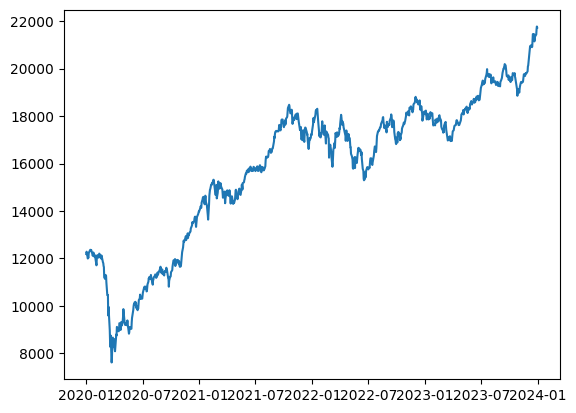

In [78]:
import matplotlib.pyplot as plt
plt.plot(nifty50['Close'])
plt.show()

In [79]:
nifty50 = nifty50.dropna()

In [80]:
x_train = nifty50['Close'][:int(len(nifty50['Close'])*0.8)]
x_test = nifty50['Close'][int(len(nifty50['Close'])*0.8):]

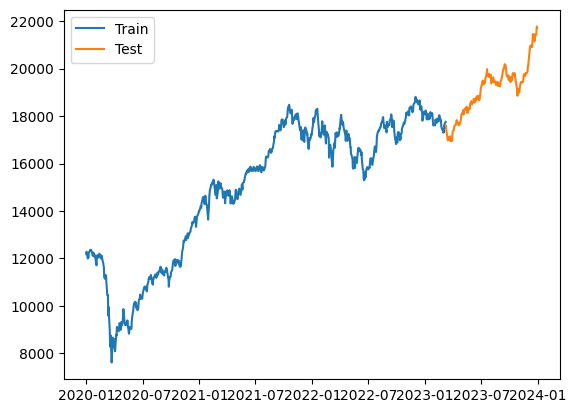

In [81]:
plt.plot(x_train, label='Train')
plt.plot(x_test, label='Test')
plt.legend()
plt.show()

In [82]:
print(x_train.shape, x_test.shape)

(792, 1) (199, 1)


In [83]:
import torch.nn as nn
import torch.nn.functional as F

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
class LSTMcell(nn.Module):
    def __init__(self, input_size,hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size + hidden_size, 4 * hidden_size)

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat((x, h_prev), dim=1)
        gates = self.fc1(combined)
        i, f, o, g = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

In [86]:
class LSTM(nn.Module):
  def __init__(self, input_size,hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMcell(input_size, hidden_size)
  def forward(self, x):
    print("Inside LSTM.forward(), x.shape =", x.shape)

    batch_size, seq_len, _ = x.shape  # this is where it crashes

    h = torch.zeros(batch_size, self.hidden_size, device=x.device)
    c = torch.zeros(batch_size, self.hidden_size, device=x.device)

    for t in range(seq_len):
        h, c = self.lstm_cell(x[:, t, :], h, c)

    return h


In [87]:
class stockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = self.lstm(x)
        out = self.fc(h)
        return out

In [88]:
model = stockLSTM(input_size=1, hidden_size=64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50


In [89]:
def sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [90]:
x_train,x_test=np.log(x_train),np.log(x_test)

In [91]:
x_train= np.array(x_train)
x_test= np.array(x_test)

In [92]:
x_train = x_train.reshape(-1)
x_test = x_test.reshape(-1)

In [93]:
print(x_train.shape, x_test.shape)

(792,) (199,)


In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))



In [95]:
x_train = scaler.fit_transform(x_train.reshape(-1, 1))
x_test = scaler.transform(x_test.reshape(-1, 1))

In [96]:
print(x_train)

[[0.51987979]
 [0.5288857 ]
 [0.52387695]
 [0.50256182]
 [0.50806682]
 [0.50553366]
 [0.52290502]
 [0.52659824]
 [0.53313721]
 [0.53606829]
 [0.53436876]
 [0.53546035]
 [0.53517858]
 [0.5236871 ]
 [0.51873181]
 [0.51300161]
 [0.51968473]
 [0.52582721]
 [0.51410533]
 [0.50832802]
 [0.51506225]
 [0.50649346]
 [0.49970664]
 [0.47597314]
 [0.50132662]
 [0.51138046]
 [0.51583175]
 [0.51222094]
 [0.50609864]
 [0.51309287]
 [0.52157457]
 [0.5191676 ]
 [0.51359922]
 [0.50741112]
 [0.50251117]
 [0.51473429]
 [0.51062151]
 [0.4873807 ]
 [0.48443447]
 [0.47319497]
 [0.46891013]
 [0.42714154]
 [0.42031433]
 [0.43711329]
 [0.43198891]
 [0.43375525]
 [0.40599929]
 [0.35053677]
 [0.35127131]
 [0.25550721]
 [0.29678613]
 [0.20930333]
 [0.18127743]
 [0.11811023]
 [0.09098768]
 [0.15362834]
 [0.        ]
 [0.02736088]
 [0.09823782]
 [0.14040973]
 [0.14281096]
 [0.09334515]
 [0.13480782]
 [0.08969654]
 [0.06670089]
 [0.15951922]
 [0.15404517]
 [0.19898364]
 [0.18457484]
 [0.17612089]
 [0.18444586]
 [0.21

In [97]:
x_train_seq,y_train_seq = sequences(x_train, seq_length=60)
x_test_seq,y_test_seq = sequences(x_test, seq_length=60)

In [98]:
x_train_seq = torch.tensor(x_train_seq, dtype=torch.float32).to(device)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32).to(device)

In [99]:
print(x_test_seq.shape,y_test_seq.shape)

(139, 60, 1) (139, 1)


In [100]:

epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(x_train_seq)
    loss = criterion(y_pred, y_train_seq)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 1, Loss: 0.738905
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 2, Loss: 0.714419
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 3, Loss: 0.690332
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 4, Loss: 0.666553
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 5, Loss: 0.643007
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 6, Loss: 0.619609
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 7, Loss: 0.596270
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 8, Loss: 0.572894
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 9, Loss: 0.549374
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 10, Loss: 0.525590
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 11, Loss: 0.501406
Inside LSTM.forward(), x.shape = torch.Size([732, 60, 1])
Epoch 12, Loss: 0.476670
Inside LSTM.f

In [101]:
x_test_seq=torch.tensor(x_test_seq,dtype=torch.float32).to(device)
y_test_seq=torch.tensor(y_test_seq,dtype=torch.float32).to(device)

In [102]:
print(x_test_seq.shape,y_test_seq.shape)

torch.Size([139, 60, 1]) torch.Size([139, 1])


In [103]:
with torch.no_grad():
    pred_log = model(x_test_seq)

pred_price = torch.exp(pred_log)


Inside LSTM.forward(), x.shape = torch.Size([139, 60, 1])


In [104]:
print(pred_log)

tensor([[0.9975],
        [0.9992],
        [1.0005],
        [1.0017],
        [1.0033],
        [1.0050],
        [1.0063],
        [1.0081],
        [1.0097],
        [1.0113],
        [1.0130],
        [1.0143],
        [1.0150],
        [1.0156],
        [1.0165],
        [1.0181],
        [1.0207],
        [1.0239],
        [1.0275],
        [1.0312],
        [1.0350],
        [1.0382],
        [1.0410],
        [1.0439],
        [1.0464],
        [1.0488],
        [1.0515],
        [1.0547],
        [1.0580],
        [1.0616],
        [1.0655],
        [1.0686],
        [1.0709],
        [1.0730],
        [1.0751],
        [1.0766],
        [1.0778],
        [1.0793],
        [1.0806],
        [1.0810],
        [1.0806],
        [1.0804],
        [1.0805],
        [1.0806],
        [1.0809],
        [1.0809],
        [1.0804],
        [1.0799],
        [1.0794],
        [1.0785],
        [1.0774],
        [1.0766],
        [1.0758],
        [1.0754],
        [1.0748],
        [1

In [105]:
pred_price = scaler.inverse_transform(pred_log.cpu().numpy())
y_test_seq = scaler.inverse_transform(y_test_seq.cpu().numpy())

In [106]:
print(pred_price.shape,y_test_seq.shape)

(139, 1) (139, 1)


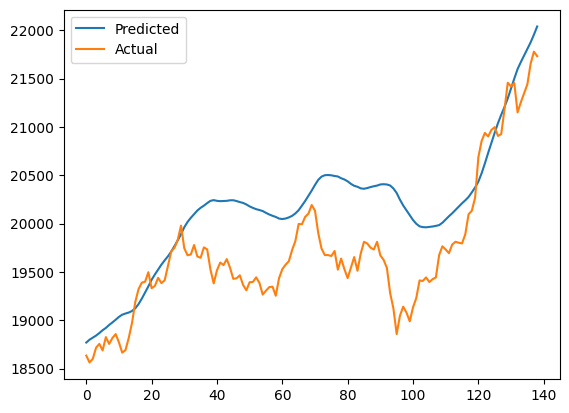

In [107]:
plt.plot(np.exp(pred_price).squeeze(-1), label='Predicted')
plt.plot(np.exp(y_test_seq).squeeze(-1), label='Actual')
plt.legend()
plt.show()



In [108]:
#### MODEL EVAL ######
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(np.exp(y_test_seq), np.exp(pred_price))
mae = mean_absolute_error(np.exp(y_test_seq), np.exp(pred_price))

In [109]:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(np.exp(y_test_seq), np.exp(pred_price))
print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}")

MSE: 320650.0, MAE: 468.9287414550781, RMSE: 566.2596435546875
